# Implementación de Modelos de ML para la Clasificación de Dobletes

## Cargando Datos

Abriendo librerias y muestra de datos...

In [1]:
import sys
import urllib.request
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import time

In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_gaussian_quantiles
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [3]:
import keras
from keras.layers import Input, Flatten, Dense
from keras.layers import concatenate, Dropout, BatchNormalization
from keras.models import Model
from keras import optimizers
from keras.constraints import max_norm
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

2025-06-16 09:23:04.555487: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750065784.830996      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750065784.906007      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
!cp /kaggle/input/balanced-1m-doublets/balanced1M_pixelTracksHitDoublets_dnn_doublets.h5  .
data_files = '/kaggle/input/balanced-1m-doublets/balanced1M_pixelTracksHitDoublets_dnn_doublets.h5'
data = pd.read_hdf(data_files)

### Preparando la Muestra de Datos

Se definen las variables de la muestra `data` que se usarán para los modelos. Para ello se define un conjunto base `myFeatures` y se generan posteriormente los nombres asociados al hit de entrada (`In`) y de salida (`Out`). De esta manera, las el conjunto de variables que se usarán quedan contenidas en `featureLabs`

In [5]:
myFeatures =  ["IsBarrel","X","Y","Z","R","Ax1","Ax2",
               "ClustX","ClustY", "ClustSize","ClustSizeX","ClustSizeY",
              "AvgCharge", "Skew"]

inMyFeatures  = [ "in" + str(i) for i in myFeatures]
outMyFeatures = [ "out" + str(i) for i in myFeatures]

featureLabs = inMyFeatures + outMyFeatures + ["deltaPhi"] 

Se añade el conjunto de variables que se usarán para que el modelo aprenda a `X`. Por otro lado en `Y` se guardan las etiquetas de clasificación de los dobletes, se asigna `1` si el doblete es `True` y `0` si es `False`. 

In [6]:
X = data[featureLabs].values
Y = np.array([1 if i == 1 else 0 for i in data["label"]])

Se comprueba que la muestra está **balanceada** para evitar sesgos entre clases:

In [7]:
print("Number of doublets: %d"%len(data))
print(f"True: {sum(Y==1)}, False: {sum(Y==0)}")

Number of doublets: 1016920
True: 508460, False: 508460


Se dividen los datos en **70% entrenamiento** (`X_train`, `Y_train`) y **30% de prueba** (`X_test`,`Y_test`) para poder evaluar el modelo posteriormente.

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

## Boosted Decission Tree (BDT)

Se crea un BDT usando el algoritmo **AdaBoost** donde se usan como clasificadores débiles **árboles de decisión** con profundidad máxima de 3

In [9]:
start = time.time()
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),
                         algorithm="SAMME",
                         n_estimators=100)
bdt.fit(X_train,Y_train)
print(f"Terminado en {time.time() - start:.2f} segundos")

Terminado en 907.07 segundos


Se calculan en `Y_predBDT` las probabilidades que predice el BDT de que la clase sea **True** para el conjunto de prueba. Además se separan las predicciones de ejemplos de clase verdadera (`true_bdt_out`) y falsa (`false_bdt_out`) para observar la distribución de la clasificación predicha.

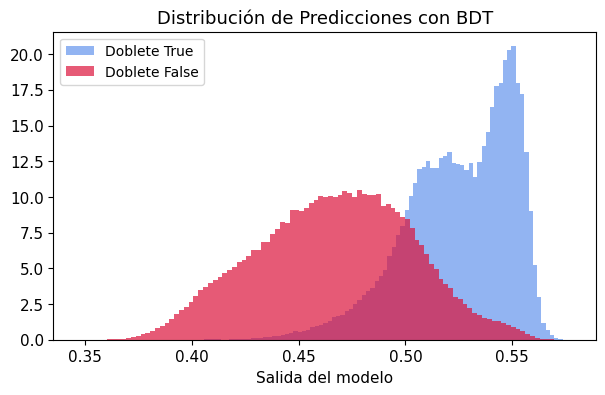

In [10]:
Y_predBDT = bdt.predict_proba(X_test)[:, 1]
true_bdt_out = Y_predBDT[Y_test == 1]
false_bdt_out = Y_predBDT[Y_test == 0]

plt.figure(figsize=(7,4))
plt.hist(true_bdt_out, bins=100, alpha=0.7, label="Doblete True", 
         color="cornflowerblue", density=True)
plt.hist(false_bdt_out, bins=100, alpha=0.7, label="Doblete False", 
         color="crimson", density=True)
plt.legend(fontsize=10)
plt.xlabel('Salida del modelo',fontsize=11)
plt.title('Distribución de Predicciones con BDT',fontsize=13)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 11)
plt.savefig('/kaggle/working/Predic_BDT.png')
plt.show()

0.9064278762188673


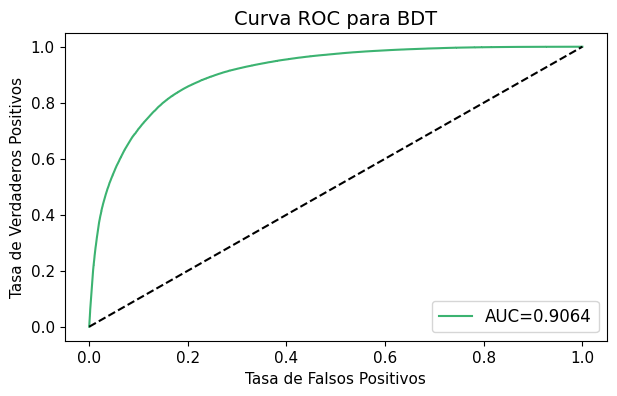

In [11]:
fpr_bdt, tpr_bdt, thresholds_bdt  = roc_curve(Y_test, Y_predBDT)
roc_auc_bdt = auc(fpr_bdt, tpr_bdt)
test_roc_bdt = roc_auc_score(Y_test, Y_predBDT)
                                                
print(test_roc_bdt)

plt.figure(figsize=(7,4))
plt.plot(fpr_bdt, tpr_bdt, label= 'AUC={:0.4f}'.format(roc_auc_bdt), 
         color='mediumseagreen')
plt.legend(loc = 'lower right',fontsize=12)
plt.plot([0,1], [0,1], 'k--')
plt.title("Curva ROC para BDT",fontsize=14)
plt.ylabel('Tasa de Verdaderos Positivos',fontsize=11)
plt.xlabel('Tasa de Falsos Positivos',fontsize=11)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 11)
plt.savefig('/kaggle/working/CurvaROC_BDT.png')
plt.show()

Se calcula la **matriz de confusión**. Para ello hace falta convertir las probabilidades predichas en etiquetas binarias, luego se define un umbral de decisión (`k`).

In [12]:
k = 0.5
Y_conf_bdt = (Y_predBDT > k).astype(int)
conf_matrix_bdt = confusion_matrix(Y_test, Y_conf_bdt)
print(conf_matrix_bdt)

[[124056  28265]
 [ 23897 128858]]


Se calculan además usando el mismo umbral de decisión, distintas **métricas** para evaluar el modelo 

In [13]:
y_pred_bdt = bdt.predict(X_test)
acc_bdt = accuracy_score(Y_test, y_pred_bdt)
print('Accuracy: '+ str(acc_bdt))

Accuracy: 0.8290196541189736


### Variación del número de árboles

A continuación se **itera sobre el número de árboles** (n_estimators) que se implementan en el modelo con el fin de observar cuál es el más adecuado, pudiendo reducir así el tiempo de ejecución y manteniendo los valores adecuados de las métricas.

Ademas se evaluan también las métricas sobre el **conjunto de entrenamiento** con el objetivo de comparar con las del conjunto de test y evaluar si existe **sobreajuste** (si las métricas son mejores en el conjunto de train que en el de test el modelo está memorizando pero no sabe generalizar a datos que no ha visto)

In [15]:
n_vals = [10, 50, 70, 100, 150, 200, 300, 400]
auc_scores = [] ; auc_train_scores = []
accur_scores = [] ; accur_train_scores = []

for n in n_vals:
    start = time.time()
    bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),
                             algorithm="SAMME",
                             n_estimators=n)
    bdt.fit(X_train, Y_train)
    end = time.time()

    y_pred = bdt.predict(X_test)
    y_proba = bdt.predict_proba(X_test)[:, 1]
    y_train_pred = bdt.predict(X_train)
    y_train_proba = bdt.predict_proba(X_train)[:, 1]
 
    auc_scores.append(roc_auc_score(Y_test, y_proba))
    accur_scores.append(accuracy_score(Y_test, y_pred))
    auc_train_scores.append(roc_auc_score(Y_train, y_train_proba))
    accur_train_scores.append(accuracy_score(Y_train, y_train_pred))

    tot_time = end - start
    print('Entrenamiento con ' + str(n) + ' árboles terminado en ' + str (tot_time) + 's')

Entrenamiento con 10 árboles terminado en 96.76109862327576s
Entrenamiento con 50 árboles terminado en 485.2728886604309s
Entrenamiento con 70 árboles terminado en 674.6931915283203s
Entrenamiento con 100 árboles terminado en 962.8486883640289s
Entrenamiento con 150 árboles terminado en 1455.524873971939s
Entrenamiento con 200 árboles terminado en 1914.6496200561523s
Entrenamiento con 300 árboles terminado en 2887.975014925003s
Entrenamiento con 400 árboles terminado en 3878.7314162254333s


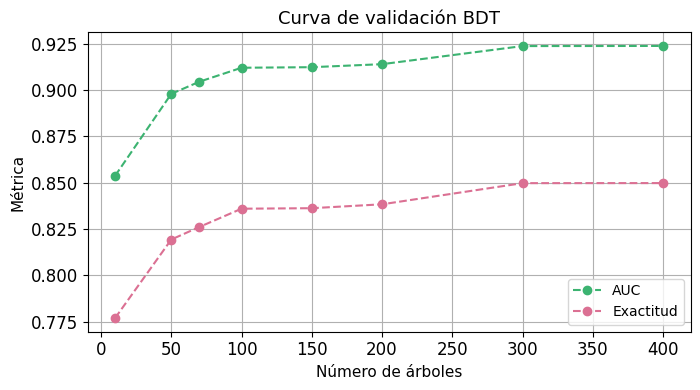

In [16]:
plt.figure(figsize=(7,4))
plt.plot(n_vals, auc_scores, 'o--', label='AUC',  color='mediumseagreen')
plt.plot(n_vals, accur_scores,'o--', label='Exactitud', color='palevioletred')
plt.xlabel('Número de árboles',fontsize=11)
plt.ylabel('Métrica',fontsize=11)
plt.title('Curva de validación BDT',fontsize=13)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
plt.legend(fontsize=10)
plt.grid() ; plt.tight_layout()
plt.savefig('/kaggle/working/validacionBDT_test.png')
plt.show()

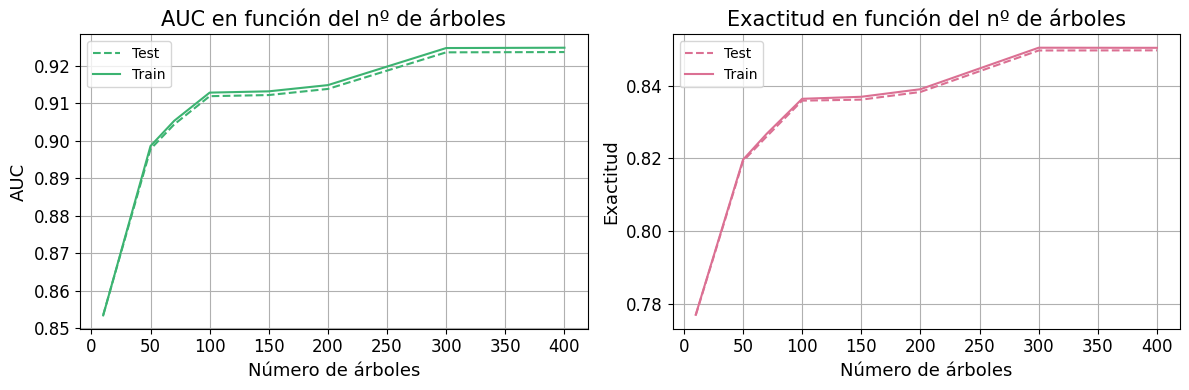

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

axs[0].plot(n_vals, auc_scores, '--', label='Test',  color='mediumseagreen')
axs[0].plot(n_vals, auc_train_scores, '-', label='Entrenamiento',  color='mediumseagreen')
axs[0].set_xlabel('Número de árboles',fontsize=13)
axs[0].set_ylabel('AUC', fontsize=13)
axs[0].set_title('AUC en función del nº de árboles', fontsize=15)
axs[0].grid()
axs[0].legend(fontsize=10)
axs[0].tick_params(axis='both', labelsize=12)

axs[1].plot(n_vals, accur_scores, '--', label='Test',  color='palevioletred')
axs[1].plot(n_vals, accur_train_scores, '-', label='Entrenamiento',  color='palevioletred')
axs[1].set_xlabel('Número de árboles',fontsize=13)
axs[1].set_ylabel('Exactitud', fontsize=13)
axs[1].set_title('Exactitud en función del nº de árboles', fontsize=15)
axs[1].grid()
axs[1].legend(fontsize=10)
axs[1].tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.savefig('/kaggle/working/BDT_overfiting.png')
plt.show()

**No** parece observarse sobreentrenamiento

## Red Neuronal Profunda (DNN)

Antes de entrenar la red neuronal, es fundamental que las variables de entrada tengan una escala similar, especialmente en este caso pues las variables presentan rangos muy diferentes entre sí. Esto ayuda que la red no le dé más importancia a aquellas variables que toman valores más altos.

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
K.clear_session()

Se define la arquitectura de la red neuronal:
* Capa de entrada `features` con mismo número de neuronas que de variables de entrada.
* Dos capas densas `dense` de 64 neuronas con función de activación ReLU
* Capa de salida `pred` con una única neurona (que representa la probabilidad de clase True) y activación sigmoide para clasificación binaria.
Esta probabilidad se refiere a la clase True pues está fue a la que se le asignó el valor positivo `1`, y porque la función de pérdida `binary_crossentropy` está diseñada para comparar la predicción con respecto a esa clase positiva.
* Además se incluyen una capa de Dropout `drop` para evitar sobreajuste

In [16]:
features   = Input(shape=(len(X_train[1]),), name='hit_input')

dense = Dense(64, activation='relu', name='dense_1')(features)
b_norm = BatchNormalization()(dense)

drop = Dropout(0.2)(b_norm)

dense = Dense(64, activation='relu', name='dense_2')(drop)
b_norm = BatchNormalization()(dense)
pred = Dense(1, activation='sigmoid', name='output')(b_norm)


model = Model(inputs=features, outputs=pred)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

2025-06-16 09:47:16.409109: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Para mejorar la eficiencia del entrenamiento y evitar sobreajuste se hace uso de  `callbacks`. Con `EarlyStopping` se detiene el entrenamiento si la estadística no mejora durante 10 épocas seguidas. 

In [17]:
callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]

A continuación se empieza el **entrenamiento** sobre el conjunto de train (`X_train` `Y_train`). Se reservan para **validación el 30%** de los datos de entrenamiento y se entrena durante 40 épocas (40 pasadas del modelo por el conjunto de entrenamiento)

In [18]:
history = model.fit(X_train_scaled, Y_train, batch_size = 1024 , epochs=40, shuffle=True, 
                    validation_split=0.3, callbacks=callbacks, verbose=0)

Representación de los datos obtenidos en el entrenamiento y evaluación de distintas métricas:

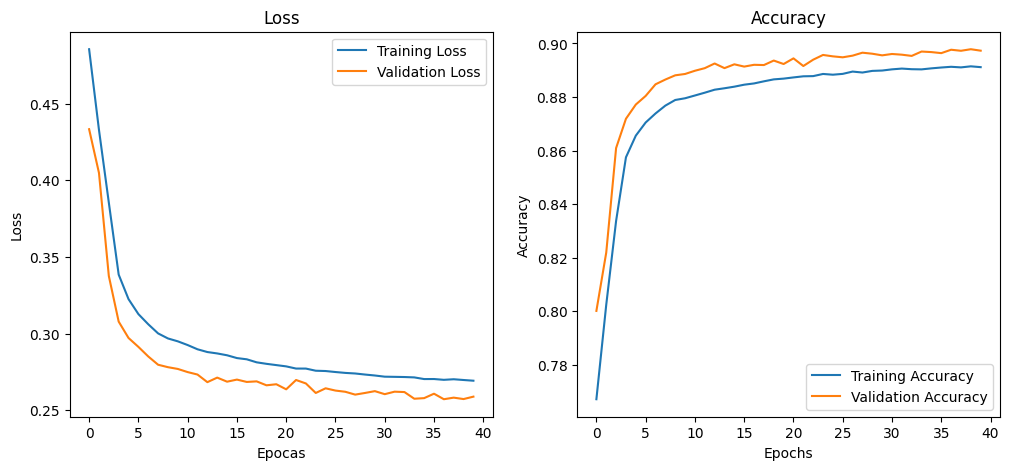

In [19]:
history_dict = history.history

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epocas')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()

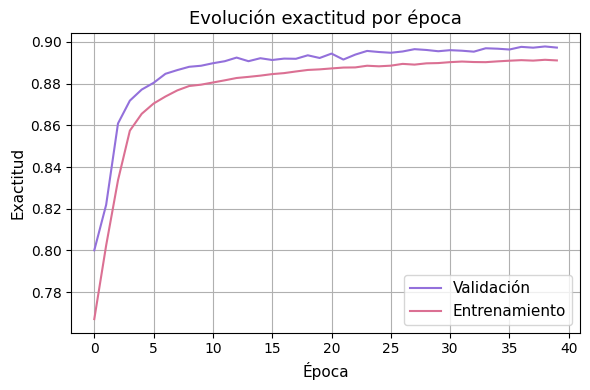

In [20]:
plt.figure(figsize=(6, 4))
plt.plot(history_dict['val_accuracy'], label='Validación', color='mediumpurple')
plt.plot(history_dict['accuracy'], label='Entrenamiento', color='palevioletred')
plt.title('Evolución exactitud por época',fontsize=13)
plt.xlabel('Época', fontsize=11)
plt.ylabel('Exactitud', fontsize=11)
plt.legend(fontsize=11)
plt.tight_layout()
plt.grid()
plt.savefig('/kaggle/working/accuracyDNN')
plt.show()

Validación y train crecen paralelas. **No se observa sobreajuste**. La curva de validación no es tan suave como la de train, es decir tiene fluctuaciones, esto se debe a que el conjunto de datos reservado para validación es mucho más pequeño que para entrenamiento.  

9534/9534 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


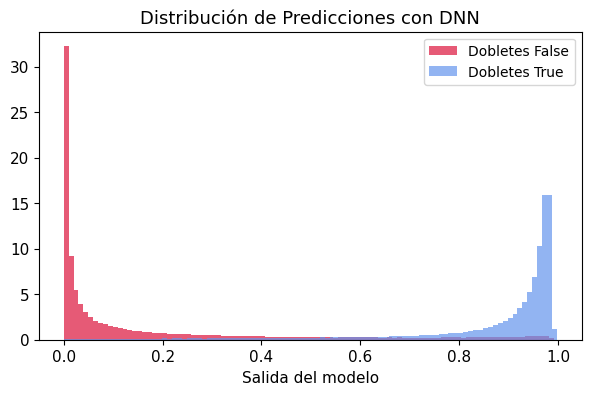

In [21]:
Y_predic = model.predict(X_test_scaled)
true_preds = Y_predic[Y_test==1] 
false_preds = Y_predic[Y_test==0] 


plt.figure(figsize=(7,4))
plt.hist(false_preds, bins=100, alpha=0.7, label="Dobletes False", 
         color="crimson", density=True)
plt.hist(true_preds, bins=100, alpha=0.7, label="Dobletes True", 
         color="cornflowerblue", density=True)
plt.legend(fontsize=10)
plt.xlabel('Salida del modelo',fontsize=11)
plt.title('Distribución de Predicciones con DNN',fontsize=13)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 11)
plt.savefig('/kaggle/working/Predic_DNN.png')
plt.show()

0.9585795033127882


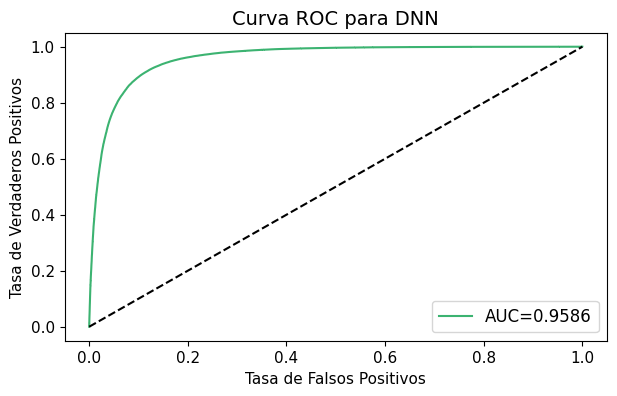

In [22]:
fpr_dnn, tpr_dnn, thresholds_dnn  = roc_curve(Y_test, Y_predic)
#roc_auc_dnn = auc(fpr_dnn, tpr_dnn) 
test_roc_dnn = roc_auc_score(Y_test, Y_predic)
print(test_roc_dnn)

plt.figure(figsize=(7,4))
plt.plot(fpr_dnn, tpr_dnn, label= 'AUC={:0.4f}'.format(test_roc_dnn), 
         color= 'mediumseagreen')
plt.legend(loc = 'lower right',fontsize=12)
plt.plot([0,1], [0,1], 'k--')
plt.title("Curva ROC para DNN",fontsize=14)
plt.ylabel('Tasa de Verdaderos Positivos',fontsize=11)
plt.xlabel('Tasa de Falsos Positivos',fontsize=11)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 11)
plt.savefig('/kaggle/working/CurvaROC_DNN.png')
plt.show()

Calcula la matriz de confusión para un umbral de decisión de k=0.5:

In [23]:
k = 0.5
Y_pred_dnn = (Y_predic > k).astype(int)
conf_matrix_dnn = confusion_matrix(Y_test, Y_pred_dnn)
print('Matriz de confusión')
print(conf_matrix_dnn)

Matriz de confusión
[[131853  20468]
 [ 11019 141736]]


In [24]:
acc_dnn = accuracy_score(Y_test, Y_pred_dnn)
print('Accuracy: ' + str(acc_dnn))

Accuracy: 0.8967896524144803


### Variación del número de neuronas por capa

In [25]:
n_neurons = [16, 32, 64, 128, 256]
acc_results = [] ; auc_results = [] ; histories = []
tiempos = []

for n in n_neurons:
    K.clear_session()
    
    features   = Input(shape=(len(X_train[1]),), name='hit_input')
    dense = Dense(n, activation='relu', name='dense_1')(features)
    b_norm = BatchNormalization()(dense)

    drop = Dropout(0.2)(b_norm)

    dense = Dense(n, activation='relu', name='dense_2')(drop)

    b_norm = BatchNormalization()(dense)
    pred = Dense(1, activation='sigmoid', name='output')(b_norm)

    model = Model(inputs=features, outputs=pred)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]

    start = time.time()
    history = model.fit(X_train_scaled, Y_train, batch_size = 1024 , epochs=40, shuffle=True, 
                    validation_split=0.3, callbacks=callbacks, verbose=0)
    histories.append(history.history) 
    
    end = time.time()
    tot_time = end - start
    tiempos.append(tot_time)

    Y_predic = model.predict(X_test_scaled)
    auc = roc_auc_score(Y_test, Y_predic)
    auc_results.append(auc)

    Y_pred_dnn = (Y_predic > 0.5).astype(int)
    acc = accuracy_score(Y_test, Y_pred_dnn)
    acc_results.append(acc)

    print(str(n) + ' neuronas por capa terminado en ' + str(tot_time) + 's')

9534/9534 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
16 neuronas por capa terminado en 87.18727016448975s
9534/9534 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
32 neuronas por capa terminado en 107.07260751724243s
9534/9534 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
64 neuronas por capa terminado en 135.1197850704193s
9534/9534 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
128 neuronas por capa terminado en 194.55995297431946s
9534/9534 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
256 neuronas por capa terminado en 297.53231596946716s


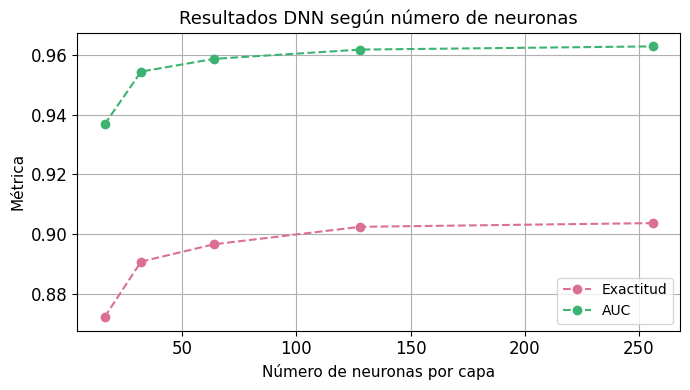

In [26]:
plt.figure(figsize=(7,4))
plt.plot(n_neurons, acc_results, 'o--', label='Exactitud', color='palevioletred')
plt.plot(n_neurons, auc_results, 'o--', label='AUC', color = 'mediumseagreen')
plt.xlabel('Número de neuronas por capa', fontsize = 11)
plt.ylabel('Métrica', fontsize = 11)
plt.title('Resultados DNN según número de neuronas',fontsize = 13)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
plt.legend(fontsize=10)
plt.grid() ; plt.tight_layout()
plt.savefig('/kaggle/working/metricasDNN_nneurons.png')
plt.show()

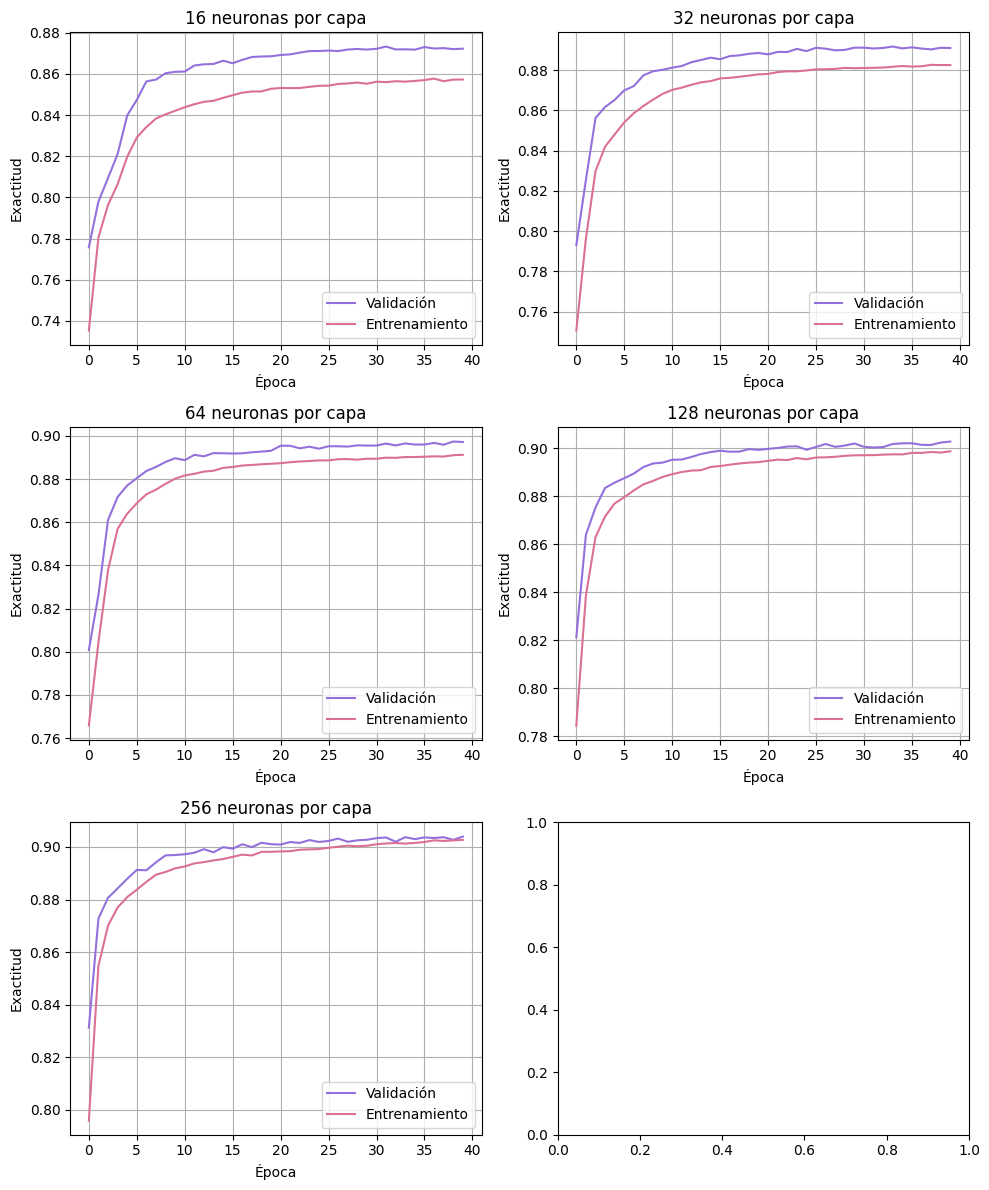

In [27]:
fig, axs = plt.subplots(3, 2, figsize=(10, 12))
axs = axs.ravel()

for i, n in enumerate(n_neurons):
    history = histories[i]
    
    axs[i].plot(history['val_accuracy'], label='Validación', color='mediumpurple')
    axs[i].plot(history['accuracy'], label='Entrenamiento', color='palevioletred')
    axs[i].set_title(f'{n} neuronas por capa')
    axs[i].set_xlabel('Época')
    axs[i].set_ylabel('Exactitud')
    axs[i].grid(True)
    axs[i].legend()

plt.tight_layout()
plt.savefig('/kaggle/working/DNN_nneuronsOVERFITING.png')
plt.show()

El que mejor combina rendimiento computacional con resultados es el de **64 neuronas**

### Variación del número de capas ocultas

In [28]:
n_layers = [1, 2, 3, 4, 5]
acc_results = [] ; auc_results = [] ; histories = []
tiempos = []

for nl in n_layers:
    K.clear_session()
    
    features   = Input(shape=(len(X_train[1]),), name='hit_input')
    x = Dense(64, activation='relu', name='dense_1')(features)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    for i in range(nl-1):
        x = Dense(64, activation='relu', name='dense_'+ str(i+2))(x)
        if i != nl - 2:  # solo añade dropout si no es la última oculta
            x = Dropout(0.2)(x)

    x = BatchNormalization()(x)
    pred = Dense(1, activation='sigmoid', name='output')(x)

    model = Model(inputs=features, outputs=pred)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
    
    start = time.time()
    history = model.fit(X_train_scaled, Y_train, batch_size = 1024 , epochs=40, shuffle=True, 
                    validation_split=0.3, callbacks=callbacks, verbose=0)
    histories.append(history.history) 
    
    end = time.time()
    tot_time = end - start
    tiempos.append(tot_time)

    Y_predic = model.predict(X_test_scaled)
    auc = roc_auc_score(Y_test, Y_predic)
    auc_results.append(auc)

    Y_pred_dnn = (Y_predic > 0.5).astype(int)
    acc = accuracy_score(Y_test, Y_pred_dnn)
    acc_results.append(acc)

    print(str(nl) + ' capas ocultas terminado en ' + str(tot_time) + 's')

9534/9534 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
1 capas ocultas terminado en 119.2864236831665s
9534/9534 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
2 capas ocultas terminado en 134.84483790397644s
9534/9534 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
3 capas ocultas terminado en 161.51702284812927s
9534/9534 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
4 capas ocultas terminado en 188.55610632896423s
9534/9534 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
5 capas ocultas terminado en 211.00967836380005s


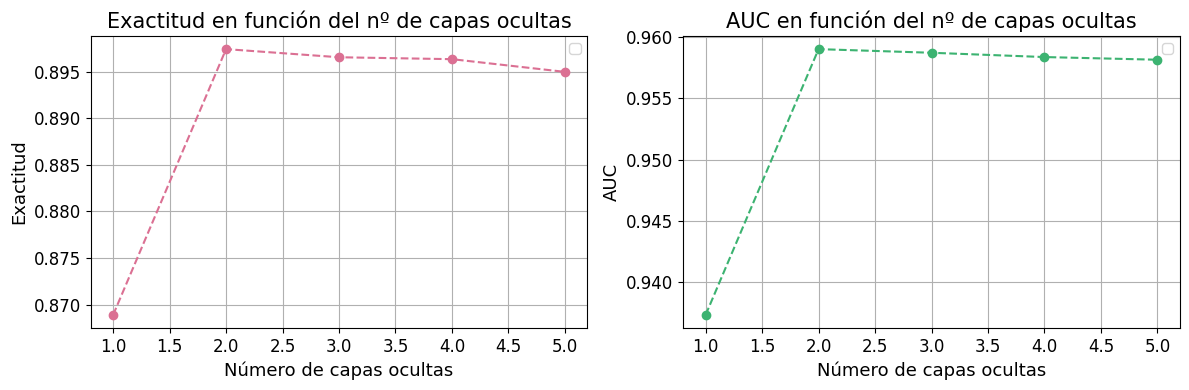

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

axs[0].plot(n_layers, acc_results, 'o--', color='palevioletred')
axs[0].set_xlabel('Número de capas ocultas', fontsize=13)
axs[0].set_ylabel('Exactitud', fontsize=13)
axs[0].set_title('Exactitud en función del nº de capas ocultas', fontsize=15)
axs[0].grid()
axs[0].legend(fontsize=10)
axs[0].tick_params(axis='both', labelsize=12)

axs[1].plot(n_layers, auc_results, 'o--', color='mediumseagreen')
axs[1].set_xlabel('Número de capas ocultas', fontsize=13)
axs[1].set_ylabel('AUC', fontsize=13)
axs[1].set_title('AUC en función del nº de capas ocultas', fontsize=15)
axs[1].grid()
axs[1].legend(fontsize=10)
axs[1].tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.savefig('/kaggle/working/metricasDNN_nlayers.png')
plt.show()

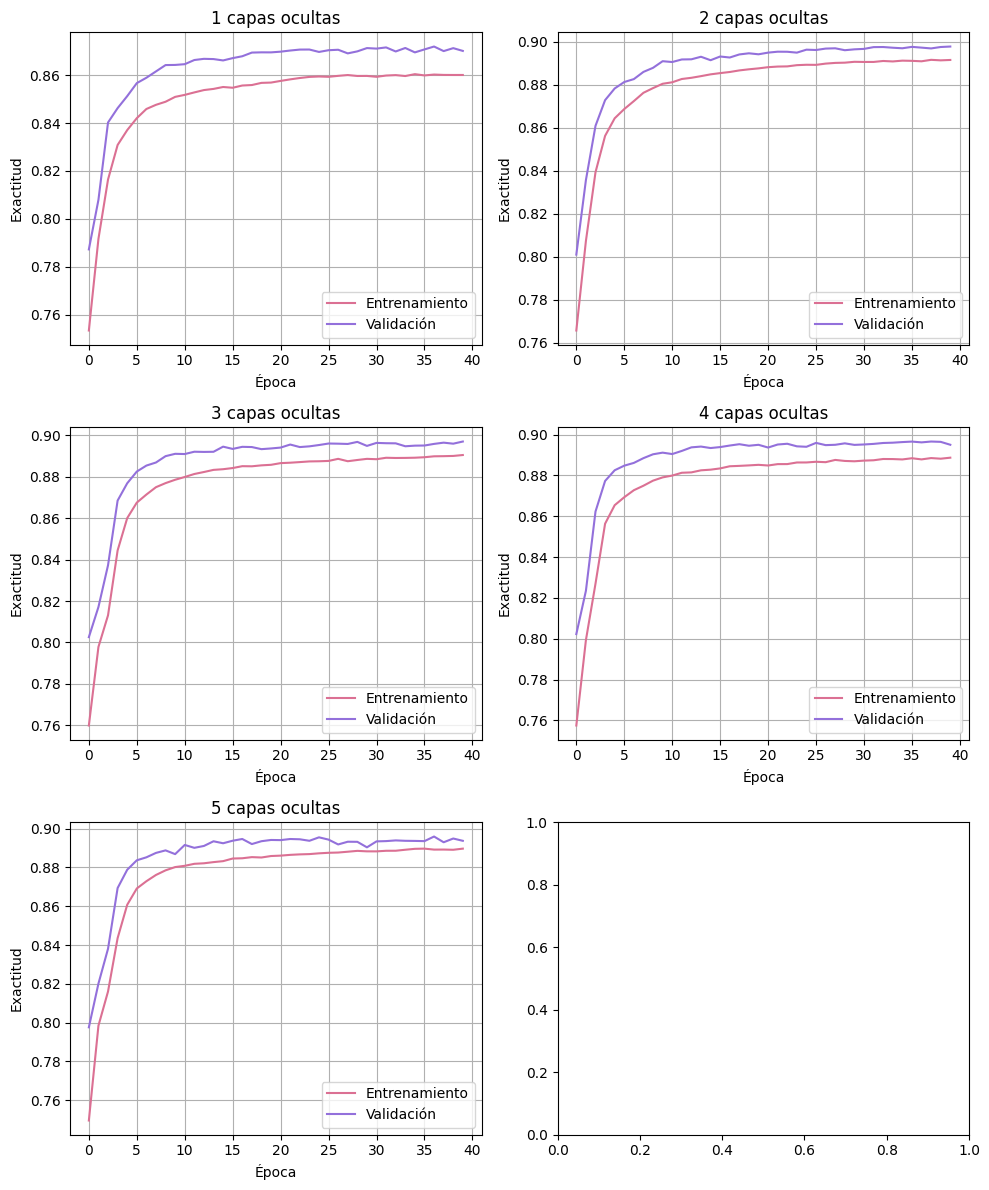

In [30]:
fig, axs = plt.subplots(3, 2, figsize=(10, 12))
axs = axs.ravel()

for i, n in enumerate(n_layers):
    history = histories[i]
    
    axs[i].plot(history['accuracy'], label='Entrenamiento', color='palevioletred')
    axs[i].plot(history['val_accuracy'], label='Validación', color='mediumpurple')
    axs[i].set_title(f'{n} capas ocultas')
    axs[i].set_xlabel('Época')
    axs[i].set_ylabel('Exactitud')
    axs[i].grid(True)
    axs[i].legend()

plt.tight_layout()
plt.savefig('/kaggle/working/DNN_nlayersOVERFITING.png')
plt.show()

El número de capas ocultas idoneo es **2 capas**

### Importancia de las variables de entrada

Para interpretar las predicciones de la red neuronal entrenada, se utiliza el método SHAP. Este asigna una importancia a cada caracteristica de entrada (conjunto `X`) en función de su correspondiente contribución a la salida del modelo. Para ello se selecciona un subconjunto balanceado y se aplica `KernelExplainer` para obtener los valores SHAP.

In [31]:
import shap

X_background = X_train_scaled[np.random.choice(X_train.shape[0], 100, replace=False)]
explainer = shap.KernelExplainer(lambda x: model.predict(x, verbose=0), X_background)

idx_1 = np.where(Y_train == 1)[0]
idx_0 = np.where(Y_train == 0)[0]
sel_1 = np.random.choice(idx_1, 500, replace=False)
sel_0 = np.random.choice(idx_0, 500, replace=False)

X_explain = np.concatenate([X_train_scaled[sel_1], X_train_scaled[sel_0]])
np.random.shuffle(X_explain)

shap_values = explainer.shap_values(X_explain)
 
#shap.summary_plot(shap_values[0], X_explain, feature_names=featureLabs)

  0%|          | 0/1000 [00:00<?, ?it/s]

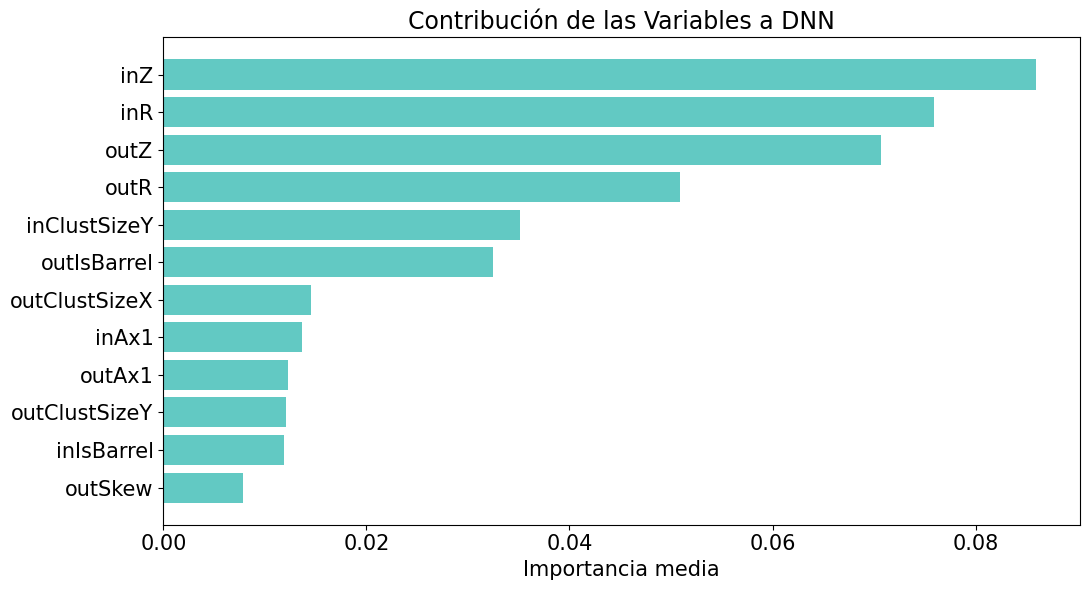

In [36]:
shap_vals = shap_values[0]
mean_abs_shap = np.abs(shap_vals).mean(axis=0)
top_indices = np.argsort(mean_abs_shap)[-12:][::-1]
top_features = [featureLabs[i] for i in top_indices]
top_importances = mean_abs_shap[top_indices]

plt.figure(figsize=(11, 6))
plt.barh(top_features, top_importances, color='lightseagreen',alpha=0.7)
plt.gca().invert_yaxis() 
plt.xlabel('Importancia media',fontsize= 15)
plt.title('Contribución de las Variables a DNN',fontsize= 17)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.tight_layout()
plt.savefig('/kaggle/working/variablesimportantes.png')
plt.show()

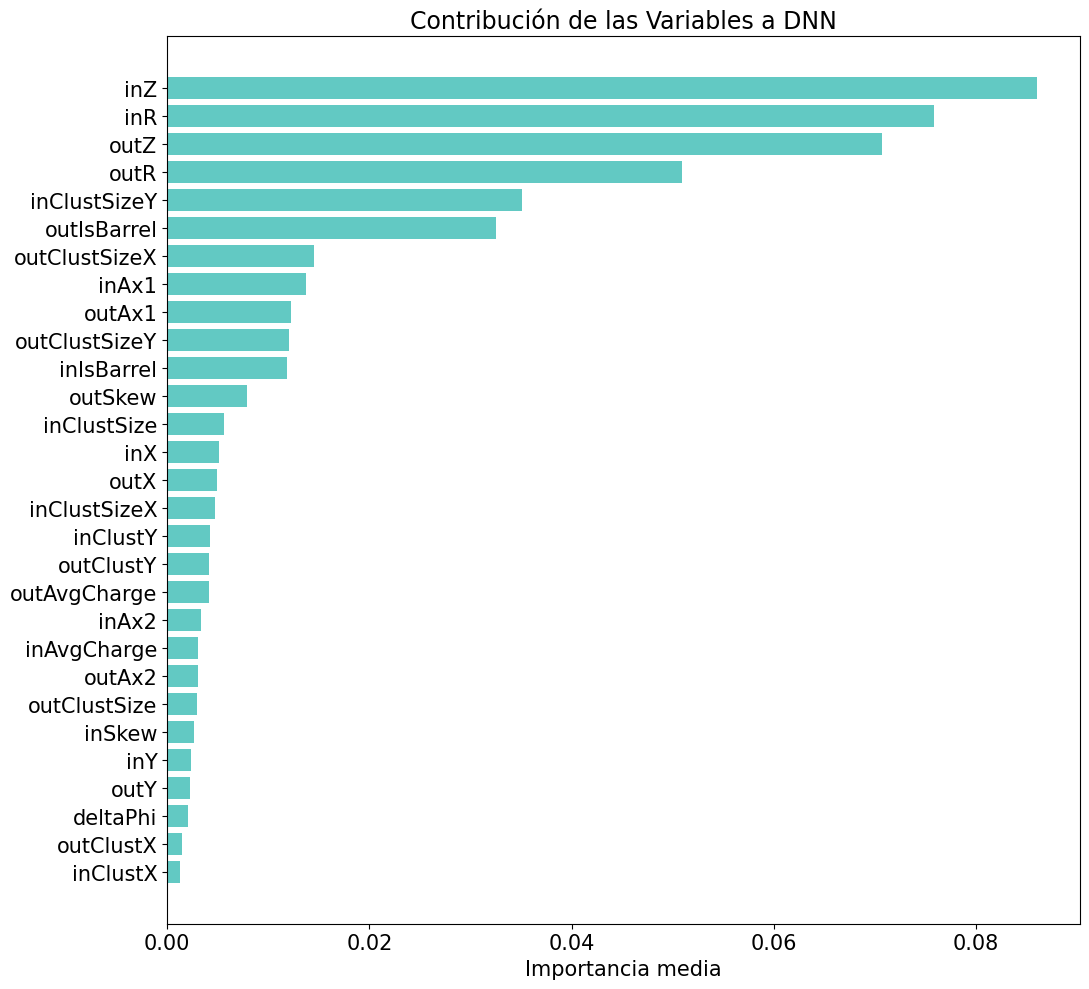

In [37]:
shap_vals = shap_values[0]
mean_abs_shap = np.abs(shap_vals).mean(axis=0)
top_indices = np.argsort(mean_abs_shap)[:][::-1]
top_features = [featureLabs[i] for i in top_indices]
top_importances = mean_abs_shap[top_indices]

plt.figure(figsize=(11, 10))
plt.barh(top_features, top_importances, color='lightseagreen',alpha=0.7)
plt.gca().invert_yaxis() 
plt.xlabel('Importancia media',fontsize= 15)
plt.title('Contribución de las Variables a DNN',fontsize= 17)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.tight_layout()
plt.savefig('/kaggle/working/todasvariablesimportantes.png')
plt.show()